### Optimerer one-hot + dense + class_weight
- **class_weight** prøves for at få mere fokus på at træne de SANDE
- prøver med mere og mindre af class_weight, epocs og modelæag
### Konklusion
- Det bliver ikke rigtigt bedr end nedenfor

In [1]:
# vi sætter stien til data
import os
import pandas as pd
import numpy as np
os.chdir('/Users/ThomasGordon/Documents/PythonScripts/FED')

# Excel-filen med tekster åbnes og indlæses
xl = pd.ExcelFile('FEDAll.xlsx')
df = xl.parse('FEDlinjer')       # siden i arket

# læs overskrifter i FED
texts  = df.loc[:,'FEDtext']
texts  = texts.values

# læs antal linjer og omsæt til "stor hændelse" eller "lille hændelse"
StorEr = 10
NumLines = df.loc[:,'FEDlinjer']
NumLines = NumLines.values
labels = np.asarray([1*(NumLines[i]>=StorEr) for i in range(len(NumLines))])

# vi rafler data rundt tilfældigt (vi laver et tilfældigt index)
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)
texts   = texts[indices]
labels = labels[indices]
NumLines = NumLines[indices]

# opdeling i training data og test data
i = 90000  # antal linjer afsat til træning, resten er test
texts_train = texts[:i]
texts_test  = texts[i:] 
labels_train = labels[:i]
labels_test  = labels[i:]
NumLines_train = NumLines[:i]
NumLines_test  = NumLines[i:]

In [2]:
# laver tekst om til vektor, henter text processing modul

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Vi ser kun på de 10.000 mest almindelige ord

# vi laver ordene i FED om til tilsvarende tal (som nedenfor laves til en "one-hot")
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# sætninger laves om til en "one hot" data vektor
# tester ...
data_train = tokenizer.texts_to_matrix(texts_train, mode='binary')
data_test  = tokenizer.texts_to_matrix(texts_test,  mode='binary')

# labels laves til vektor
labels_train = np.asarray(labels_train).astype('float32')
labels_test = np.asarray(labels_test).astype('float32')

# print størrelsen på train og test data
print(data_train.shape)
print(data_test.shape)
print(labels_train.shape)
print(labels_test.shape)

(90000, 10000)
(10867, 10000)
(90000,)
(10867,)


In [4]:
# modellen laves

from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 160,577
Trainable params: 160,577
Non-trainable params: 0
_________________________________________________________________


In [5]:
# modellen trænes
NumEpochs = 14
class_weight = {0: 1., 1: 26.}
history = model.fit(data_train, labels_train,
                    epochs=NumEpochs,
                    batch_size=512,
                    validation_split=0.1,
                    class_weight=class_weight)
history_dict = history.history
history_dict.keys()

Train on 81000 samples, validate on 9000 samples
Epoch 1/14
81000/81000 [==============================] - 18s 217us/step - loss: 1.2611 - acc: 0.6779 - val_loss: 1.0890 - val_acc: 0.7829
Epoch 2/14
81000/81000 [==============================] - 17s 208us/step - loss: 1.0977 - acc: 0.7628 - val_loss: 1.0375 - val_acc: 0.8354
Epoch 3/14
81000/81000 [==============================] - 17s 206us/step - loss: 1.0317 - acc: 0.8199 - val_loss: 1.0439 - val_acc: 0.8299
Epoch 4/14
81000/81000 [==============================] - 15s 184us/step - loss: 0.9962 - acc: 0.8367 - val_loss: 1.0650 - val_acc: 0.8440
Epoch 5/14
81000/81000 [==============================] - 16s 198us/step - loss: 0.9745 - acc: 0.8486 - val_loss: 1.0772 - val_acc: 0.8401
Epoch 6/14
81000/81000 [==============================] - 14s 174us/step - loss: 0.9547 - acc: 0.8548 - val_loss: 1.0836 - val_acc: 0.8491
Epoch 7/14
81000/81000 [==============================] - 15s 186us/step - loss: 0.9253 - acc: 0.8629 - val_loss: 1.1

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [6]:
# initialiser plot
import matplotlib.pyplot as plt
plt.show()

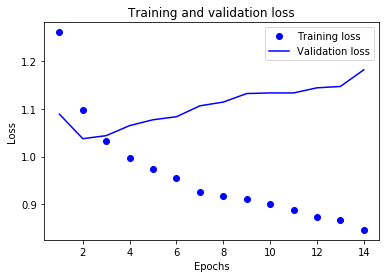

In [7]:
# plotter historikken for 'loss' og 'accuracy'
accu = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, NumEpochs+1)

plt.plot(epochs, loss, 'bo', label='Training loss')       # "bo" = "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # "b"  = "solid blue line"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

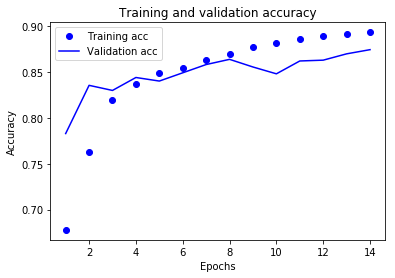

In [8]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Validering af modellen på test data
Her indlæser vi så test data, helt nye data til test

In [9]:
# vi prøver modellen på test-data
predictions = model.predict(data_test)
for i in range(1,10):
    print(('%1.4f' % predictions[i]))

0.3316
0.3551
0.0429
0.0943
0.2148
0.4907
0.9594
0.5006
0.0054


In [10]:
# finder ud af hvor stor en del store, som er fundet
print('Antal store i datasættet:    ', sum(labels_test))
NumEstimated = 0
for i in range(1,len(labels_test)):
    if predictions[i]>0.5 and labels_test[i]:
        NumEstimated += 1
print('antal estimeret af modellen: ', NumEstimated)
print('Modellens præcision:         ', round(NumEstimated/sum(labels_test)*100), '%')

# Gennemsnittet for rigtig og forkert
print(' Gennemsnit for test stor og lille')
print(np.average([x for i, x in enumerate(predictions) if labels_test[i]]))
print(np.average([x for i, x in enumerate(predictions) if not labels_test[i]]))

Antal store i datasættet:     425.0
antal estimeret af modellen:  220
Modellens præcision:          52.0 %
 Gennemsnit for test stor og lille
0.57154226
0.27807298


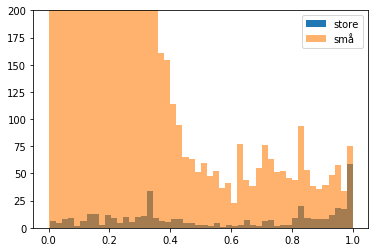

In [11]:
# jeg prøver lige at plotte "predictions i et histogram

# hent data for store og små i to arrays, lav til et np array, så plotteren kan forstå data
PlotDataSand = [x for i, x in enumerate(predictions) if labels_test[i]]
PlotDataSand = np.array(PlotDataSand)
PlotDataFalsk = [x for i, x in enumerate(predictions) if not labels_test[i]]
PlotDataFalsk = np.array(PlotDataFalsk)

plt.clf()  # clear figure
plt.hist(PlotDataSand, bins=50, alpha=1, label='store')  # 50 bins, halv hennemsigtig
plt.hist(PlotDataFalsk, bins=50, alpha=0.6, label='små')
plt.legend(loc='upper right')
plt.ylim([0, 200])

plt.show()

In [12]:
# print hvilke tekster de forskellige typer består af
print('SANDE i test-sættet, som har SMÅ predictions (men burde være store!):')
print('-'*40)
print('Lines Predict Text')
for i in range(1,2000):
    if labels_test[i]==1 and predictions[i] < 0.3:
        PrtStr = ('%5.0f' % NumLines_test[i]) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 
print()
        
print('SANDE i test-sættet, som har STORE predictions (men burde være store!):')
print('-'*40)
print('Lines Predict Text')
for i in range(1,2000):
    if labels_test[i]==1 and predictions[i] > 0.5:
        PrtStr = ('%5.0f' % NumLines_test[i]) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 
print()

print('FALSKE i test-sættet, som har STORE predictions (men burde være store!):')
print('-'*40)
print('Lines Predict Text')
for i in range(1,2000):
    if labels_test[i]==0 and predictions[i] > 0.5:
        PrtStr = ('%5.0f' % NumLines_test[i]) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 
print()

SANDE i test-sættet, som har SMÅ predictions (men burde være store!):
----------------------------------------
Lines Predict Text
   14  0.1266  Disponering Dsb: ekstra stop HH
   10  0.2618  Materielfejl, holder med teknisket problemer i Viby.  Tgf oplyser at de ca. havde 150 passager i
   12  0.2513  Materieldisponering DSB, mgl ET
   37  0.2096  Øvrige Banedanmark. Tidligere i dag, blev et lyslederkabel gravet over ved Ka. Det har givet 5-10 mi
   12  0.0054  Materielfejl ET Hg, de blev meldt nedbrudt i går i Hg spor 3 efter ank. i 2059 pag. røgudviklingf. K
   10  0.2850  Kommer sent til perron i Cph pga 1045 har en påkørsel lige før Cph
   29  0.0615  Melding modtager 0:16 Sporspærringen Hk - Mø bliver ikke færdig, forventes først færdig omkring kl 1
   12  0.1449  Oprettet 06:18 Kan ikke koble
   14  0.2808  Materielmangel DD : Mangler materiel til morgen trafikken
   10  0.0125  Banedanmark/DSB        Strømafbrydelse i KAV   fra 00:50 til 04:30   hvilket betyder at alt kørsel i
